# Ejecución de modelos RFSM con python


08/10/2021

**Salvador Navas Fernández** ([IH Cantabria](https://ihcantabria.com/), Santander, Spain)

<img src="https://ihcantabria.com/wp-content/uploads/2020/07/Logo-IHCantabria-Universidad-Cantabria-cmyk.png" alt="drawing" width="500"/>

En lo últimos años el avance de python y QGIS han permitido ir ganando terreno a ArcGIS cuya licencia no es libre. Por tanto en este trabajo se han realizado funciones que permiten realizar el trabajo en cualquier sistema operativo y de forma más optimizada y automática. El objetivo principal es el elaborar los inputs de partida del modelo RFSM y su ejecución, de esta forma se ha conseguido reducir lo tiempos de cómputo del proceso.

A continuación se muestra un ejemplo de principio a fin de cómo elaborar y proyecto de RFSM, su ejecución y la obtención de resultados.

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from RFSM_python.impactzones import *
from RFSM_python.perfiles import *
from RFSM_python.manning import *
from RFSM_python.tursBC import *
from RFSM_python.executionRFSM import *
from RFSM_python.dinamicas import *
from RFSM_python.TWL import *
from RFSM_python.configRFSM import *
from RFSM_python.executionRFSM import *
from RFSM_python.kml import *
from RFSM_python.preproceso import *

import warnings
from datetime import datetime, timedelta
import os
warnings.filterwarnings('ignore')

# INPUT

En primer lugar es necesario configurar los nombres de los path donde se va a trabajar además de la configuración inicial del modelo RFSM.
Previamente se tiene que tener ya la carpeta configurada, es decir con la siguiente distribución de carpetas que se obtiene al ejecutar las siguientes líneas. 

```
project
└───ascii
└───bin
└───demos
└───doc
└───scripts
└───shp
└───src
└───test
```



In [3]:
path_project      = 'E:/Github/RFSM/tests/MURCIA/RFSM/' # Directorio donde se va a localizar el proyecto, es decir donde se va a simular el modelo
COTA_ESTUDIO      = 10
cellsize          = 5
path_output       = path_project+'ascii/'
DTM         = '../tests/MURCIA/DATA_IN/MDT/mdt.asc' # El MDT debe de tener un proyección asignada, sino dará error
path_install_RFSM  = '../tests/IHRFSM_v1.0/'
CoastLine_Polygon  = '../tests/MURCIA/DATA_IN/Coastline/Coastline_Polygon.shp'  # Tiene que ser un polígono
CoastLine_Polyline = '../tests/MURCIA/DATA_IN/Coastline/Coastline_Polyline.shp' # Tiene que ser una polilínea
make_dirs_RFSM(path_install_RFSM,path_project)

Una vez creadas las carpetas Lo más importante es que las carpetas contengan los ficheros necesarios, lo más importante es la carpeta ascii de donde partiremos para preprar el modelo. En esta carpeta se deben de encontrar los ficheros que se crean tras la ejecución de 'AccData'.

```
project
└───ascii
│   │   floodareas.asc
│   │   tblCell.csv
│   │   tblImpactZone.csv
│   │   tblIZNbrWidth.csv
│   │   tblIZNeighbour.csv
│   │   tblIZVolume.csv
│   │   tblParameters.csv
│   │   topography.asc
│   └───check
│       │   acccells_izid.csv
│       │   cellid.asc
│       │   dirdrainage.asc
│       │   izid1.asc
│       │   izid2.asc
│───bin
│───demos
│───doc
│───scripts
│───shp
│───src
│───test
```


Una vez que se han obtenido la malla de proyecto de estudio, se procede a la ejecución del proceso para obtener los inputs necesarios del modelo RFSM

# Preproceso

In [4]:
preprocess_RFSM(DTM,COTA_ESTUDIO,path_project,epsg_n ="25830",CoastLine=CoastLine_Polygon)

Creating output E:/Github/RFSM/tests/MURCIA/RFSM/shp/Final_CUT.shp of format ESRI Shapefile.


# IMPACT ZONES

__Esta líneas se ejecutan una vez que se han obtenido las mallas de ACCDATA__

In [5]:
DTM_CLIP_LC = '../tests/MURCIA/RFSM/ascii/DTM_LC.asc' # MDT que se ha cortado con la linea de costa en el proceso anterior, 
                                                      # si este mdt se ha realizado a través de gis, introducir el directorio donde se encuentre el mdt

In [6]:
Table_impact_zone, izcoast = impact_zones_process(path_project,DTM_CLIP_LC,cellsize=cellsize,COTA_ESTUDIO = COTA_ESTUDIO, new_coast_Line = True)

Creating output E:/Github/RFSM/tests/MURCIA/RFSM/shp/DTM_OC.shp of format ESRI Shapefile.
Creating output E:/Github/RFSM/tests/MURCIA/RFSM/shp/izid1.shp of format ESRI Shapefile.
Creating output E:/Github/RFSM/tests/MURCIA/RFSM/shp/izid2.shp of format ESRI Shapefile.
Creating output E:/Github/RFSM/tests/MURCIA/RFSM/shp/coast_IH.shp of format ESRI Shapefile.
95.81868004798889


Una vez que se ha ejecutado la línea anterior se crean dentro de la carpeta **shp** y **ascii** ficheros importantes para la configuración del modelo RFSM
```
project
└───ascii
│   │   izcoast.csv
│   │   tblImpactZone.csv
└───shp
│   │  izcoast.shp
```

El fichero **izcoast.shp** son las ImpactZones donde se incoporan las condiciones de contorno asociadas a *nivel* o *rebase*, pero en ocasiones cuando el corte del mdt no es limpio se generan celdas de contorno que no son correctas, por tanto es necesario modificar eliminando estas celdas del fichero **izcoast.shp**. Al nuevo fichero creado le llamamos **izcoast_2.shp** Para modificar la tabla de *izcoast* Se ejecuta la siguiente línea de código obteniendo como resultado otro fichero csv llamado **izcoast_def.csv** que será utilizado para las condiciones de contorno de RFSM.

In [7]:
izcoast_modify(path_project,path_project+'shp/izcoast_2.shp', path_project+'ascii/izcoast.csv', path_project+'ascii/izcoast_def.csv')

# PERFILES BATIMETRÍA

Uno de los parámetros necesarios necesarios en las características de los puntos de TWL es la pendiente de la costa. Como datos de partida es necesaria una linea de costa y la batimetría. La batimetría puede ser utilizada como curvas de nivel o a través de un raster.

En este ejemplo se puede utilizar los dos formatos ya que se ha descargado la batimetría de la zona de estudio de la [Ecocartografía](https://www.miteco.gob.es/es/costas/temas/proteccion-costa/ecocartografias/default.aspx) y se ha generado un raster a partir de la interpolación de las curvas de nivel. Es necesario destacar que la descarga de la Batimetría de la Ecocartografía es en formato KML por lo que a través de QGIS es necesario exportarla a shape ya que la cota no está asignada a la geometría sino que está fuera.

Los parámetros que se introducen son:
* SPAC = que es la separación que se quiere entre perfiles
* Ltierra = longitud del perfil desde la linea de costa hacia tierra
* Lmar = longitud del perfil hacia el mar. Siempre el perfil tiene que superar el punto de dinámicas
* Postierra = **1** Si en el sentido de avance de la línea de costa la tierra está a la izquierda **0** Si en el sentido de avance de la línea de costa la tierra está a la derecha
* plott = **1** si se quiere plotear los perfiles y **0** si no se quiere

Una vez que se generan los perfiles es necesario editarlo en GIS para evitar que se crucen o que haya perfiles fuera de la batimetría. También en ocasiones cuando se utilizan curvas de nivel es necesario verificar que todos los perfiles cruzan las curvas de nivel. Sino sería necesario editarlo también.


In [8]:
SPAC = 800
Ltierra = 200
Lmar = 1000
Postierra = 0
plott = 1
EPSG  = 25830

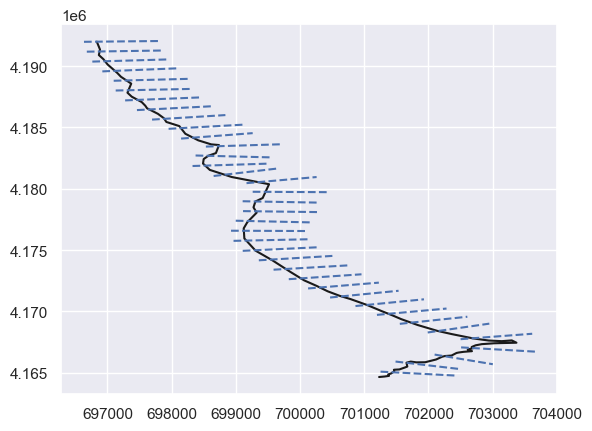

In [9]:
traza_perfiles_linea('../tests/MURCIA/DATA_IN/Perfiles/linea_costa_suavizada.shp',
                     SPAC,Ltierra,Lmar,Postierra,plott,path_output='../tests/MURCIA/DATA_IN/Perfiles/')

Una vez modificado el shape de perfiles llamado **Cross_Sections.shp** se jecuta la siguiente línea para actualizar la tabla de atributos y generar el fichero de perfiles final **Cross_Sections_Final.shp**

In [10]:
correct_perfiles_linea('../tests/MURCIA/DATA_IN/Perfiles/Cross_Sections.shp',path_output='../tests/MURCIA/DATA_IN/Perfiles/')

A continuación se calcula la pendiente para cada uno de los perfiles y se obtiene el fichero **Cross_Sections_mforshore**.

In [11]:
calculate_mforshore('../tests/MURCIA/DATA_IN/Batimetria/Batimetria.tif', 
                    '../tests/MURCIA/DATA_IN/Perfiles/Cross_Sections_Final.shp', EPSG, '../tests/MURCIA/DATA_IN/Perfiles/')

Además de la línea de costa suavizada en este punto es necesario tener creado el fichero de puntos de TWL donde se reconstruyen las dinámicas. La tabla de atributos del fichero tiene que tener los siguientes campos:
* CX	
* CY
* Lon
* Lat
* mforeshore: pendiente intermareal (foreshore)	
* ksetup:     coeficiente de minoración o mayoración de la componente del setup en el TWL	
* kswash:     coeficiente de minoración o mayoración de la componente del swash en el TWL	
* ktide:      coeficiente de minoración o mayoración de la marea astronómica
* kr:         coeficiciente de reducción del oleaje (difracción, interior estuario)	

Una vez calculada la pendiente de los perfiles, a cada punto de TWL (**puntos_TWL.shp**) se le asigna la pendiente del perfil más cercano.

In [12]:
update_mforeshore_TWL('../tests/MURCIA/DATA_IN/Perfiles/Cross_Sections_mforshore.shp',
                      '../tests/MURCIA/DATA_IN/TWL/puntos_TWL.shp',25830,
                      '../tests/MURCIA/DATA_IN/TWL/')

# DINÁMICAS

Las dinámicas son proporcionadas en formato '.mat' em puntos distribuidos a los largo de la costa. Sin embargo en python es complejo leer este tipo de ficheros y trabajo con ellos, por lo que la mejor forma de llevar a cabo to el proceso del cálculo de TWL es a partir de ficheros **netcdf**. Por esta razón se han creado una serie de funciones que convierten los ficheros **.mat** de información de oleaje y marea en ficheros netcdf. Es necesario destacar que las funciones está preparadas para utilizarlas con escenarios de cambio climático.

<img src="http://www.gisandbeers.com/wp-content/uploads/2018/10/Archivos-NetCDF.jpg" alt="drawing" width="500"/>

In [13]:
create_netcf_Dinamicas_DOW('../tests/MURCIA/DATA_IN/Dinamicas/','../tests/MURCIA/DATA_IN/Dinamicas/netcdf/','DOW','his')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.48it/s]


In [14]:
create_netcf_MareaAst('../tests/MURCIA/DATA_IN/Dinamicas/marea_astronomica/','../tests/MURCIA/DATA_IN/Dinamicas/netcdf/')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


#  Cálculo de las condiciones de contorno
Una vez que se han pasado las dinámicas a formato netcdf se comienza a preparar las condiciones de contorno a través del cálculo estadístico de los periodos de retorno de la variable de estudio (nivel o caudal)

### Definimos variables y escenarios

In [15]:
refANMM = 0.1731         # diferencia entre el sistema de referencia de las mareas (NMML) y el MDT (En la España peninsular, NMMA)
dur_half = 5             #duración de media tormenta
T = [5, 10, 25, 50, 100, 500] # Periodos de retorno que queremos obtener del ajuste de extremos del TWL
timehis_ini ='2020-01-10 00:00:00'
timehis_fin ='2020-01-24 00:00:00'
timehis    = '2020-01-20 02:00:00' #fecha del pico de la tormenta Gloria, 2 de la mañana

puntos_CC = '../tests/MURCIA/DATA_IN/TWL/puntos_TWL_foreshore.shp'

In [16]:
# cargamos el shapefile con información del tipo de costa, difracción, marea y río
CC = gpd.read_file(puntos_CC) # cargo el archivo puntos definidos para el cálculo del TWL con todos los atributos que contiene
CCx = CC.CX # coordenada x utm
CCy = CC.CY # coordenada y utm
CClon = CC.Lon # longitud
CClat = CC.Lat # latitud
kswash = CC.kswash # coeficiente de minoración o mayoración de la componente del swash en el TWL
ksetup = CC.ksetup # coeficiente de minoración o mayoración de la componente del setup en el TWL
kr = CC.kr # coeficiciente de reducción del oleaje (difracción, interior estuario)
mfore = CC.mforeshore # pendiente intermareal (foreshore)
ktide = CC.ktide # coeficiente de minoración o mayoración de la marea astronómica

### Cálculo del TWL

In [17]:
[TWL_serie,HS_serie,PMVE_serie] = generate_files_extrems('../tests/MURCIA/DATA_IN/Dinamicas/netcdf/','../tests/MURCIA/DATA_IN/TWL/',puntos_CC,T, refANMM, 'gumbel', 25830, plot=False)

Calculando TWL


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:20<00:00,  2.79it/s]


#### Ectracción de la tormenta de referencia

A continuación extraemos de las series de TWL buscamos la ventana temporal y el pico de una tormenta histórica de referencia (p.ej. en el Mediterráneo, tormenta Gloria)
<img src="https://www.laprensa.hn/binrepository/1030x580/5c0/1020d580/none/11004/PAXX/tormenta-gloria-olas-14-metros-espana_LP1350705_MG5939624.jpg" alt="drawing" width="500"/>

De la tormenta extraemos el máximo en cada uno de los puntos donde se ha calculado el TWL y la fecha cuando se produce 

In [18]:
TWL_Tormenta     = TWL_serie.loc[timehis_ini:timehis_fin] # Identificamos la tormenta

In [19]:
Max_TWL_Tormenta = TWL_Tormenta.max() # Identificamos el máximo
Fecha_Max_TWL    = pd.to_datetime(TWL_Tormenta.index[TWL_Tormenta.values.argmax(axis=0)]) # Identificamos la fecha cuando se produce

Además de la tormenta de referencia se cualcula el TWL de una tormenta de considerando una duración típica de las tormentas de la zona

In [20]:
TWLpeak = []
for i in range(0,len(TWL_serie.columns)):
    TWLpeak.append(TWL_serie.loc[Fecha_Max_TWL[i]+timedelta(hours=-dur_half):Fecha_Max_TWL[i]+timedelta(hours=+dur_half),i].max())

# Inputs RFSM y Ejecución

Una vez calculados los valores de las condiciones de contorno que se desean analizar comenzamos a contruir los ficheros de entrada del modelo RFSM.

Para configurar cada uno de los escenarios es necesario definir un evento temporal.

In [21]:
n_periods = 10
T1 = np.arange(1,n_periods-1,2)/n_periods # Definido la longitud del período se contruye la primera parte del hidrograma. Esta sería la línea a modificar si
                                          # se quiere otra tormenta tipo
T2 = T1[::-1]  # Esta es la segunda parte del hidrograma, que se la primera parte ordenada a la inversa

In [22]:
storm = np.concatenate((T1,[1],T2))

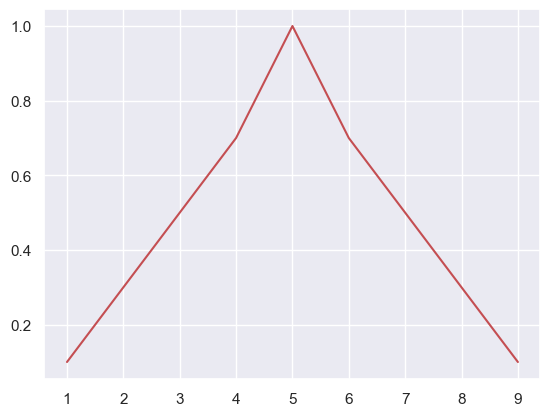

In [23]:
plt.plot(np.arange(1,len(storm)+1),storm,'-r' )

Una vez que la tormenta es construida se multiplica por el valor de TWL y el caso de la pleamar se introduce el evento directamente

In [24]:
path_outputs = 'E:/Github/RFSM/tests/MURCIA/DATA_IN/TWL/'

In [25]:
Table_impact_zone = pd.read_csv(path_project+'ascii/tblImpactZone.csv',index_col=0)
izcoast           = pd.read_csv(path_project+'ascii/izcoast.csv',index_col=0)

## Pleamar Viva Equinoccial PMVE

In [26]:
PMVE_serie = pd.read_csv(path_outputs+'Evento_PMVE.csv',index_col=0)

In [27]:
n_periods         = len(PMVE_serie)
TestID            = 1
BCSetID           = 1
BCTypeID_COAST    = 2 # 1 overtopping; # 2 level
TestDesc          = 'PMVE'
Results           = '1'
make_dirs(path_project,TestDesc,Results)

In [28]:
StartTime = '0#h'
EndTime = str(n_periods)+'#h'
TimeStep = 1
SaveTimeStep = '20#m'
MaxTimeStep = 100
MinTimeStep = 0.0001
AlphaParameter = 0.7
ManningGlobalValue = 0.035

In [29]:
tusrBCFlowLevel(table_points      = 'E:/Github/RFSM/tests/MURCIA/DATA_IN/TWL/puntos_TWL_foreshore.shp',
                table_inputs      = PMVE_serie,
                path_project      = path_project,
                TestDesc          = TestDesc,
                Table_impact_zone = pd.read_csv(path_project+'ascii/tblImpactZone.csv',index_col=0),
                izcoast           = pd.read_csv(path_project+'ascii/izcoast.csv',index_col=0),
                BCSetID           =BCSetID,
                BCTypeID_COAST    =2,
                raw_q=False, point_X_river = None ,point_Y_river = None ,hidrograma=None)

100%|████████████████████████████████████████████████████████████████████████████| 1822/1822 [00:00<00:00, 2182.71it/s]


#### Manning

In [30]:
create_file_manning(path_project,'E:/Github/RFSM/tests/MURCIA/DATA_IN/rugosidad',BCSetID,TestDesc,Table_impact_zone)

100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:03<00:00, 6502.04it/s]


#### Create XML

In [31]:
create_xml(TestID,TestDesc,BCSetID,StartTime,EndTime,TimeStep,SaveTimeStep,MaxTimeStep,MinTimeStep,AlphaParameter,ManningGlobalValue,path_project,Results)

#### Ejecución 

In [34]:
execute_RFSM(path_project,TestDesc,TestID)

Assuming windows!


#### Leer y exportar resultados

In [38]:
export_result_RFSM(path_project,TestDesc,Results,src=25830)

100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:04<00:00, 4247.04it/s]


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

## TWL Periodos de Retorno

A continuación se recorren cada uno de los períodos de retorno y se simulan

In [39]:
n_periods         = 10
TestID            = 1
BCSetID           = 1
BCTypeID_COAST    = 2 # 1 overtopping; # 2 level
Results           = '1'

In [40]:
StartTime = '0#h'
EndTime = str(n_periods)+'#h'
TimeStep = 1
SaveTimeStep = '20#m'
MaxTimeStep = 100
MinTimeStep = 0.0001
AlphaParameter = 0.7
ManningGlobalValue = 0.035

In [41]:
TWL = pd.read_csv(path_outputs+'TWL_extrem_ROW.csv',index_col=0)

In [43]:
for i in [5, 10, 25, 50, 100, 500]:
    
    TWL_Pr            = TWL.loc[:,str(i)]
    TestDesc          = 'TR_'+str(i)
    
    make_dirs(path_project,TestDesc,Results)
    
    TWL_serie = pd.DataFrame((storm*TWL_Pr.values.reshape(-1,1)).T,index=np.arange(0,len(storm)),columns=TWL.index)
    
    tusrBCFlowLevel(table_points      = 'E:/Github/RFSM/tests/MURCIA/DATA_IN/TWL/puntos_TWL_foreshore.shp',
                table_inputs      = TWL_serie,
                path_project      = path_project,
                TestDesc          = TestDesc,
                Table_impact_zone = pd.read_csv(path_project+'ascii/tblImpactZone.csv',index_col=0),
                izcoast           = pd.read_csv(path_project+'ascii/izcoast.csv',index_col=0),
                BCSetID           =BCSetID,
                BCTypeID_COAST    =2,
                raw_q=False, point_X_river = None ,point_Y_river = None ,hidrograma=None)
    
    create_file_manning(path_project,'E:/Github/RFSM/tests/MURCIA/DATA_IN/rugosidad',BCSetID,TestDesc,Table_impact_zone)
    
    create_xml(TestID,TestDesc,BCSetID,StartTime,EndTime,TimeStep,SaveTimeStep,MaxTimeStep,MinTimeStep,AlphaParameter,ManningGlobalValue,path_project,Results)
    
    execute_RFSM(path_project,TestDesc,TestID)
    
    export_result_RFSM(path_project,TestDesc,Results,25830)

100%|█████████████████████████████████████████████████████████████████████████| 21083/21083 [00:01<00:00, 15197.28it/s]


Assuming windows!


100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:02<00:00, 8579.59it/s]


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:03<00:00, 6498.33it/s]


Assuming windows!


100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:04<00:00, 4298.97it/s]


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:03<00:00, 6512.01it/s]


Assuming windows!


100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:04<00:00, 4317.87it/s]


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:03<00:00, 6516.77it/s]


Assuming windows!


100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:04<00:00, 4260.32it/s]


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:03<00:00, 6563.44it/s]


Assuming windows!


100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:04<00:00, 4278.81it/s]


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:03<00:00, 6497.50it/s]


Assuming windows!


100%|██████████████████████████████████████████████████████████████████████████| 21083/21083 [00:04<00:00, 4280.64it/s]


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

# Generación de KML

Mediante este código se pueden generar kml a partir de los raster de inundación obtenidos de RFSM.

Es necesario tener instalado python y la librería gdal que es a partir de la cual se montan los kml que posteriormente se pueden ver en un visor o Google Earth

<img src="imagen_kml.PNG" alt="drawing" width="700"/>

In [ ]:
files_TIF = list()
for root, dirs, files in os.walk(path_project):
    for file in files:
        if file.startswith("MaxLevel_") and file.endswith('.tif'):
            files_TIF.append(os.path.join(root, file))

In [ ]:
path_file_color = 'E:/Github/RFSM/notebooks/KML/col.txt' # carpeta donde se encuentra el fichero de la banda de colores que se van a utilizar para representar los calados
path_output     = 'E:/Github/RFSM/tests/MURCIA/RFSM/kml/'

In [ ]:
os.chdir(path_output)
for i in tqdm.tqdm(files_TIF):
    if os.path.exists(i[:-4]):
        continue
    else:
        os.system('gdaldem color-relief '+i+' '+path_file_color+' '+i[:-4]+'_Kml.TIF')
        os.makedirs(path_output+i.split('\\')[-1][:-4], exist_ok=True)
        gdal2tiles('-a 0 -p geodetic -k '+i[:-4]+'_kml.TIF ' + path_output+i.split('\\')[-1][:-4])

In [ ]:
files_TIF_KML = list()
for root, dirs, files in os.walk(path_project):
    for file in files:
        if file.endswith('_Kml.TIF'):
            files_TIF_KML.append(os.path.join(root, file))

In [ ]:
for i in tqdm.tqdm(files_TIF_KML):
    create_legend_kml(i[:-8]+'.TIF', 
                      path_output+i.split('\\')[-1][:-8]+'/doc.kml', 
                      path_output+i.split('\\')[-1][:-8]+'/',
                      i.split('\\')[-1][:-8])

### Generar KMZ a partir de los ficheros KML

In [ ]:
directory = list()
for i in os.listdir(path_output):
    if i.startswith('MaxLevel_'):
        directory.append(i)

In [ ]:
for i in tqdm.tqdm(directory):
    print(i)
    os.chdir(path_output)
    zipf = zipfile.ZipFile(i+'.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(i, zipf)
    zipf.close()
    pre, ext = os.path.splitext(i+'.zip')
    os.rename(i+'.zip', pre + '.kmz')
    #copyfile(pre + '.kmz', path_output+pre[:-4]+'.kmz')